# SVM ASSIGNMENT

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


### 1.2 preprocessing of project_subject_categories

In [4]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.3 preprocessing of project_subject_subcategories

In [5]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [6]:
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
print(cols)

['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'Date', 'project_grade_category', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved', 'clean_categories', 'clean_subcategories']


In [7]:
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])

In [8]:
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   

      clean_categories                 clean_subcategories  
55660     Math_Science  AppliedSciences Health_LifeScience  
76127     SpecialNeeds                        SpecialNeeds

In [9]:
y=project_data['project_is_approved']

In [10]:
Y=y

In [11]:
project_data.drop(['project_is_approved'],axis=1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660         8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127        37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   
51140        74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           Mrs.   
473         100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           Mrs.   
41558        33679  p137682  06f6e62e17de34fcf81020c77549e1d5           Mrs.   
29891       146723  p099708  c0a28c79fe8ad5810da49de47b3fb491           Mrs.   
81565        95963  p155767  e50367a62524e11fbd2dc79651b6df21           Mrs.   
79026       139722  p182545  22460c54072bd0cf958cc8349fac8b8f            Ms.   
23374        72317  p087808  598621c141cda5fb184ee7e8ccdd3fcc            Ms.   
86551       114684  p049177  679f50f18ce50aabcc602d17f7627206           Mrs.   
49228        57854  p099430  4000cfe0c8b2df75a218347c1765e283            Ms.   
72638       166022  p120079  8e22592f19b346df505bbdf6144c28d5            Mr.   
7176         79341  p091436  bb2599c4a114d211b3381abe9f899bf8           Mrs.   
70898       128817  p239087  11a60ddd63717c59fdd5a13ea92d34aa           Mrs.   
102755      127145  p203619  85c61480f0eaea60734523665a3838b4           Mrs.   
72593       104404  p258140  341dc52d3229176eda913da90b6c19c7           Mrs.   
35006       149397  p131036  bf5bf59287e7c676a634a00284596b64           Mrs.   
100222      179302  p199881  82ae813a6e2dc0da592de93861a69561           Mrs.   
5145         50256  p203475  63e9a9f2c9811a247f1aa32ee6f92644           Mrs.   
48237       139237  p147271  7f2072d18c67087af27066f60b2c9d85           Mrs.   
64637       146737  p224791  ff5d658932d9ad0d9ebedabea582648e           Mrs.   
98973        14427  p058390  578585b8ab7349189837e9618ca0f7f4           Mrs.   
52282        59671  p061990  03093ad866c578b107d5be6957837c5f            Mr.   
46375       148085  p196567  171f782b55614c56213131bcb8d44e06           Mrs.   
83528        12619  p023504  18c82623ff01c59e593f7d81ab11e62c            Ms.   
36468       121622  p138958  57626865698278199f753dc0f8e3ed00            Ms.   
36358       135897  p092089  44ab4df75ae4e8b9bb23b818a7a1b1a4           Mrs.   
39438       123970  p136762  362f046c8551fa0b2515f99d6e3ce6ea            Mr.   
72117       165036  p042345  3c2efbcac105fc8a55df610ed03f4e77           Mrs.   
2521        164738  p248458  40da977f63fb3d85589a063471304b11            Ms.   
...            ...      ...                               ...            ...   
65527        73173  p011863  e9a57ff541d9965373d9f05baec6dbb9           Mrs.   
24226        63258  p185518  783c9da904d2902781a4205a8a6f2cf2            Ms.   
35609       110157  p093760  7c0bb16f949a62e91151789662b27675           Mrs.   
57692       180842  p113135  ea758136dee04fab896aac935276161d           Mrs.   
96905        94252  p095511  d0b4f2709a391b3953bca7e4d0655992            Ms.   
27437        67820  p117003  a22232bad54f69e12f379fe86f3f8828            Ms.   
86437        84481  p140704  e36637824051b8a2edc16c6ec0eb4832            Mr.   
64442        28930  p079867  6240693c06f02e3bb63e89afa413f379            Mr.   
60130       180481  p036737  b2f85df8fe445189b1e56d7b6561adbe           Mrs.   
61773       169090  p162286  68c376fb8289fafb9831d0c886669fd1            Ms.   
83452        28565  p215499  194004c4aee808bcd24deff39b3acdb8            Ms.   
78852        71940  p038577  e8e0311f1765ef3a427a0c4da811a5fe            Ms.   
62763       150872  p149431  f308097ab4af3a20ad3d96b13083b9c4            Ms.   
98383        20564  p021779  504e698d91890380ff7e278e3918bb2f            Mr.   
108896      180953  p075974  3654cb255584baee31fded55e9fa593b           Mrs.   
5403         61360  p007550  05677e17e14429f6942245da50bd3da4           Mrs.   
18892        60690  p243246  1c6ad7948ab442bad6f72fd8ad64dd7f           Mrs.   
56589         3550  p215525  f09efb73f135c77ed938ca4df6a33ff5            Ms.   
21335   

In [12]:
X=project_data

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## 1.3 Text preprocessing

In [14]:
X_cv["essay"] = X_cv["project_essay_1"].map(str) +\
                        X_cv["project_essay_2"].map(str) + \
                        X_cv["project_essay_3"].map(str) + \
                        X_cv["project_essay_4"].map(str)

In [15]:
X_train["essay"] = X_train["project_essay_1"].map(str) +\
                        X_train["project_essay_2"].map(str) + \
                        X_train["project_essay_3"].map(str) + \
                        X_train["project_essay_4"].map(str)

In [16]:
X_test["essay"] = X_test["project_essay_1"].map(str) +\
                        X_test["project_essay_2"].map(str) + \
                        X_test["project_essay_3"].map(str) + \
                        X_test["project_essay_4"].map(str)

In [17]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
from tqdm import tqdm
preprocessed_essays_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays_train.append(sent.lower().strip())

100%|███████████████████████████████████| 49041/49041 [00:56<00:00, 866.63it/s]


In [20]:
from tqdm import tqdm
preprocessed_essays_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays_cv .append(sent.lower().strip())

100%|███████████████████████████████████| 24155/24155 [00:28<00:00, 860.17it/s]


In [21]:
from tqdm import tqdm
preprocessed_essays_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays_test.append(sent.lower().strip())

100%|███████████████████████████████████| 36052/36052 [00:41<00:00, 860.50it/s]


## 1.4 Preprocessing of `project_title`

In [22]:
from tqdm import tqdm
preprocessed_titles_train = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles_train.append(sent.lower().strip())

100%|█████████████████████████████████| 49041/49041 [00:02<00:00, 19155.55it/s]


In [23]:
from tqdm import tqdm
preprocessed_titles_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles_cv.append(sent.lower().strip())

100%|█████████████████████████████████| 24155/24155 [00:01<00:00, 18870.02it/s]


In [24]:
from tqdm import tqdm
preprocessed_titles_test = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles_test.append(sent.lower().strip())

100%|█████████████████████████████████| 36052/36052 [00:01<00:00, 18963.67it/s]


## 1.5 Preparing data for models

In [25]:
X_train['project_grade_category']=X_train['project_grade_category'].replace('Grades 3-5','Grades_3-5')
X_train['project_grade_category']=X_train['project_grade_category'].replace('Grades PreK-2','Grades_PreK-2')
X_train['project_grade_category']=X_train['project_grade_category'].replace('Grades 6-8','Grades_6-8')
X_train['project_grade_category']=X_train['project_grade_category'].replace('Grades 9-12','Grades_9-12')

In [26]:
X_cv['project_grade_category']=X_cv['project_grade_category'].replace('Grades 3-5','Grades_3-5')
X_cv['project_grade_category']=X_cv['project_grade_category'].replace('Grades PreK-2','Grades_PreK-2')
X_cv['project_grade_category']=X_cv['project_grade_category'].replace('Grades 6-8','Grades_6-8')
X_cv['project_grade_category']=X_cv['project_grade_category'].replace('Grades 9-12','Grades_9-12')

In [27]:
X_test['project_grade_category']=X_test['project_grade_category'].replace('Grades 3-5','Grades_3-5')
X_test['project_grade_category']=X_test['project_grade_category'].replace('Grades PreK-2','Grades_PreK-2')
X_test['project_grade_category']=X_test['project_grade_category'].replace('Grades 6-8','Grades_6-8')
X_test['project_grade_category']=X_test['project_grade_category'].replace('Grades 9-12','Grades_9-12')

In [28]:
print(X_train[X_train["teacher_prefix"].isnull()])

      Unnamed: 0       id                        teacher_id teacher_prefix  \
7820       17809  p180947  834f75f1b5e24bd10abe9c3dbf7ba12f            NaN   

     school_state                Date project_grade_category  \
7820           CA 2016-11-04 00:15:45             Grades_3-5   

                                         project_title  \
7820  1:7 Increasing Tech to Decrease Achievement Gaps   

                                        project_essay_1  \
7820  The children at Anna Yates Elementary school a...   

                                        project_essay_2 project_essay_3  \
7820  My goal is to bring in 1 laptop for every 7 st...             NaN   

     project_essay_4                           project_resource_summary  \
7820             NaN  My students need a classroom laptop that is ju...   

      teacher_number_of_previously_posted_projects  project_is_approved  \
7820                                             1                    1   

                    clean

In [30]:
X_train['teacher_prefix'][7820]='Mr.'
#X_train['teacher_prefix'][57654]='Mr.'
#X_train['teacher_prefix'][30368]='Mr.'

In [31]:
print(X_train[X_train["teacher_prefix"].isnull()])

Empty DataFrame
Columns: [Unnamed: 0, id, teacher_id, teacher_prefix, school_state, Date, project_grade_category, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, clean_categories, clean_subcategories, essay]
Index: []


In [32]:
print(X_cv[X_cv["teacher_prefix"].isnull()])

       Unnamed: 0       id                        teacher_id teacher_prefix  \
30368       22174  p002730  339bd5a9e445d68a74d65b99cd325397            NaN   
57654      158692  p197901  e4be6aaaa887d4202df2b647fbfc82bb            NaN   

      school_state                Date project_grade_category  \
30368           SC 2016-05-09 09:38:40            Grades_9-12   
57654           PA 2016-06-03 10:15:05             Grades_3-5   

                 project_title  \
30368  iPads for STEM Stations   
57654          Document Camera   

                                         project_essay_1  \
30368  Within the next 20 years, every job will invol...   
57654  Students at Robertsdale Elementary live in a l...   

                                         project_essay_2  \
30368  The students in our school come from a wide va...   
57654  This SMART Document Camera will improve my stu...   

                                         project_essay_3  \
30368  Students will use the iPad station

In [33]:
X_cv['teacher_prefix'][57654]='Mr.'
X_cv['teacher_prefix'][30368]='Mr.'

In [34]:
print(X_cv[X_cv["teacher_prefix"].isnull()])

Empty DataFrame
Columns: [Unnamed: 0, id, teacher_id, teacher_prefix, school_state, Date, project_grade_category, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, clean_categories, clean_subcategories, essay]
Index: []


In [35]:
print(X_test[X_test["teacher_prefix"].isnull()])

Empty DataFrame
Columns: [Unnamed: 0, id, teacher_id, teacher_prefix, school_state, Date, project_grade_category, project_title, project_essay_1, project_essay_2, project_essay_3, project_essay_4, project_resource_summary, teacher_number_of_previously_posted_projects, project_is_approved, clean_categories, clean_subcategories, essay]
Index: []


In [36]:
#X_test['teacher_prefix'][7820]='Mr.'

## Hot encoding of project subject categories


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_pro_sub_cat = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_pro_sub_cat.fit(X_train['clean_categories'].values)
print(vectorizer_pro_sub_cat.get_feature_names())

categories_one_hot_train = vectorizer_pro_sub_cat.transform(X_train['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_train.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (49041, 9)


In [38]:
categories_one_hot_test = vectorizer_pro_sub_cat.transform(X_test['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_test.shape)

Shape of matrix after one hot encodig  (36052, 9)


In [39]:
categories_one_hot_cv = vectorizer_pro_sub_cat.transform(X_cv['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_cv.shape)

Shape of matrix after one hot encodig  (24155, 9)


## Hot encoding of project subject sub categories


In [40]:
vectorizer_sub = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub.fit(X_train['clean_subcategories'].values)
print(vectorizer_sub.get_feature_names())
sub_categories_one_hot_train=vectorizer_sub.transform(X_train['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_train.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (49041, 30)


In [41]:
sub_categories_one_hot_test = vectorizer_sub.transform(X_test['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_test.shape)

Shape of matrix after one hot encodig  (36052, 30)


In [42]:
sub_categories_one_hot_cv = vectorizer_sub.transform(X_cv['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_cv.shape)

Shape of matrix after one hot encodig  (24155, 30)


## Hot encoding of state


In [43]:
from collections import Counter
my_counter_train=Counter()
for word in X_train['school_state'].values:
    my_counter_train.update(word.split())
print(my_counter_train)

Counter({'CA': 6839, 'TX': 3321, 'NY': 3264, 'FL': 2812, 'NC': 2247, 'IL': 1928, 'GA': 1848, 'SC': 1768, 'MI': 1470, 'PA': 1419, 'IN': 1161, 'MO': 1157, 'WA': 1093, 'LA': 1092, 'MA': 1086, 'OH': 1051, 'NJ': 997, 'OK': 995, 'AZ': 970, 'VA': 910, 'WI': 790, 'AL': 783, 'UT': 772, 'TN': 758, 'CT': 749, 'MD': 667, 'NV': 622, 'MS': 597, 'KY': 589, 'OR': 578, 'MN': 542, 'CO': 534, 'AR': 487, 'ID': 307, 'IA': 294, 'KS': 284, 'NM': 243, 'HI': 235, 'DC': 228, 'ME': 227, 'WV': 210, 'NH': 165, 'DE': 161, 'AK': 161, 'RI': 136, 'NE': 131, 'SD': 121, 'MT': 105, 'ND': 55, 'WY': 49, 'VT': 33})


In [44]:
state_dict_train=dict(my_counter_train)
sorted_state_dict_train=dict(sorted(state_dict_train.items(),key=lambda kv:kv[1] ))
print(sorted_state_dict_train)

{'VT': 33, 'WY': 49, 'ND': 55, 'MT': 105, 'SD': 121, 'NE': 131, 'RI': 136, 'DE': 161, 'AK': 161, 'NH': 165, 'WV': 210, 'ME': 227, 'DC': 228, 'HI': 235, 'NM': 243, 'KS': 284, 'IA': 294, 'ID': 307, 'AR': 487, 'CO': 534, 'MN': 542, 'OR': 578, 'KY': 589, 'MS': 597, 'NV': 622, 'MD': 667, 'CT': 749, 'TN': 758, 'UT': 772, 'AL': 783, 'WI': 790, 'VA': 910, 'AZ': 970, 'OK': 995, 'NJ': 997, 'OH': 1051, 'MA': 1086, 'LA': 1092, 'WA': 1093, 'MO': 1157, 'IN': 1161, 'PA': 1419, 'MI': 1470, 'SC': 1768, 'GA': 1848, 'IL': 1928, 'NC': 2247, 'FL': 2812, 'NY': 3264, 'TX': 3321, 'CA': 6839}


In [45]:
vectorizer_train = CountVectorizer(vocabulary=list(sorted_state_dict_train.keys()), lowercase=False, binary=True)
vectorizer_train.fit(X_train['school_state'].values)
print(vectorizer_train.get_feature_names())

categories_one_hot_train_tp  = vectorizer_train.transform(X_train['school_state'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_train_tp.shape)

['VT', 'WY', 'ND', 'MT', 'SD', 'NE', 'RI', 'DE', 'AK', 'NH', 'WV', 'ME', 'DC', 'HI', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'OK', 'NJ', 'OH', 'MA', 'LA', 'WA', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encodig  (49041, 51)


In [46]:
my_counter_test=Counter()
for word in X_test['school_state'].values:
    my_counter_test.update(word.split())
print(my_counter_test)

Counter({'CA': 5112, 'TX': 2475, 'NY': 2435, 'FL': 1992, 'NC': 1678, 'IL': 1438, 'SC': 1288, 'GA': 1273, 'MI': 1034, 'PA': 1001, 'OH': 866, 'IN': 858, 'MO': 840, 'OK': 794, 'LA': 768, 'MA': 757, 'NJ': 744, 'WA': 736, 'AZ': 694, 'VA': 669, 'WI': 643, 'AL': 567, 'UT': 565, 'CT': 549, 'TN': 548, 'MD': 526, 'NV': 438, 'KY': 432, 'MS': 425, 'MN': 408, 'OR': 379, 'AR': 361, 'CO': 343, 'ID': 219, 'IA': 219, 'KS': 218, 'WV': 189, 'NM': 188, 'DC': 183, 'ME': 182, 'HI': 166, 'NH': 122, 'DE': 117, 'AK': 112, 'NE': 107, 'RI': 101, 'SD': 95, 'MT': 93, 'ND': 51, 'WY': 29, 'VT': 25})


In [47]:
state_dict_test=dict(my_counter_test)
sorted_state_dict_test=dict(sorted(state_dict_test.items(),key=lambda kv:kv[1] ))
print(sorted_state_dict_test)

{'VT': 25, 'WY': 29, 'ND': 51, 'MT': 93, 'SD': 95, 'RI': 101, 'NE': 107, 'AK': 112, 'DE': 117, 'NH': 122, 'HI': 166, 'ME': 182, 'DC': 183, 'NM': 188, 'WV': 189, 'KS': 218, 'ID': 219, 'IA': 219, 'CO': 343, 'AR': 361, 'OR': 379, 'MN': 408, 'MS': 425, 'KY': 432, 'NV': 438, 'MD': 526, 'TN': 548, 'CT': 549, 'UT': 565, 'AL': 567, 'WI': 643, 'VA': 669, 'AZ': 694, 'WA': 736, 'NJ': 744, 'MA': 757, 'LA': 768, 'OK': 794, 'MO': 840, 'IN': 858, 'OH': 866, 'PA': 1001, 'MI': 1034, 'GA': 1273, 'SC': 1288, 'IL': 1438, 'NC': 1678, 'FL': 1992, 'NY': 2435, 'TX': 2475, 'CA': 5112}


In [48]:
categories_one_hot_test_tp  = vectorizer_train.transform(X_test['school_state'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_test_tp.shape)

Shape of matrix after one hot encodig  (36052, 51)


In [49]:
categories_one_hot_cv_tp  = vectorizer_train.transform(X_cv['school_state'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_cv_tp.shape)

Shape of matrix after one hot encodig  (24155, 51)


## Hot encoding of categorical data(teacher prefix)

In [50]:
from collections import Counter
my_counter_train=Counter()
for word in X_train['teacher_prefix'].values:
    my_counter_train.update(word.split())
print(my_counter_train)
teacher_dict_train = dict(my_counter_train)
sorted_teacher_dict_train = dict(sorted(teacher_dict_train.items(), key=lambda kv: kv[1]))
print(sorted_teacher_dict_train)

Counter({'Mrs.': 25749, 'Ms.': 17460, 'Mr.': 4751, 'Teacher': 1075, 'Dr.': 6})
{'Dr.': 6, 'Teacher': 1075, 'Mr.': 4751, 'Ms.': 17460, 'Mrs.': 25749}


In [51]:
vectorizer_train_tp = CountVectorizer(vocabulary=list(sorted_teacher_dict_train.keys()), lowercase=False, binary=True)
teacher_one_hot_train = vectorizer_train_tp.fit_transform(X_train['teacher_prefix'].values)
print(vectorizer_train_tp.get_feature_names())
print("Shape of matrix after one hot encodig ",teacher_one_hot_train.shape)

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encodig  (49041, 5)


In [52]:
my_counter_test=Counter()
for word in X_test['teacher_prefix'].values:
    my_counter_test.update(word.split())
print(my_counter_test)
teacher_dict_test = dict(my_counter_test)
sorted_teacher_dict_test = dict(sorted(teacher_dict_test.items(), key=lambda kv: kv[1]))
print(sorted_teacher_dict_test)

Counter({'Mrs.': 18944, 'Ms.': 12859, 'Mr.': 3489, 'Teacher': 754, 'Dr.': 6})
{'Dr.': 6, 'Teacher': 754, 'Mr.': 3489, 'Ms.': 12859, 'Mrs.': 18944}


In [53]:
vectorizer_train_tp = CountVectorizer(vocabulary=list(sorted_teacher_dict_train.keys()), lowercase=False, binary=True)
teacher_one_hot_test = vectorizer_train_tp.transform(X_test['teacher_prefix'].values)
print(vectorizer_train_tp.get_feature_names())
print("Shape of matrix after one hot encodig ",teacher_one_hot_test.shape)

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encodig  (36052, 5)


In [54]:
teacher_one_hot_cv = vectorizer_train_tp.transform(X_cv['teacher_prefix'].values)
print(vectorizer_train_tp.get_feature_names())
print("Shape of matrix after one hot encodig ",teacher_one_hot_cv.shape)

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encodig  (24155, 5)


## project_grade_category : categorical data (one hot encoding)


In [55]:
my_counter_grade=Counter()
for word in X_train['project_grade_category'].values:
    my_counter_grade.update(word.split())
print(my_counter_grade)
grade_dict = dict(my_counter_grade)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

Counter({'Grades_PreK-2': 20048, 'Grades_3-5': 16496, 'Grades_6-8': 7569, 'Grades_9-12': 4928})


In [56]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_grade = CountVectorizer(vocabulary=list(sorted_grade_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)
print(vectorizer_grade.get_feature_names())


categories_one_hot_grade = vectorizer_grade.transform(X_train['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_grade.shape)

['Grades_9-12', 'Grades_6-8', 'Grades_3-5', 'Grades_PreK-2']
Shape of matrix after one hot encodig  (49041, 4)


In [57]:
categories_one_hot_grade_test = vectorizer_grade.transform(X_test['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_grade_test.shape)

Shape of matrix after one hot encodig  (36052, 4)


In [58]:
my_counter_grade_cv=Counter()
for word in X_cv['project_grade_category'].values:
    my_counter_grade_cv.update(word.split())
print(my_counter_grade_cv)
grade_dict_cv = dict(my_counter_grade_cv)
sorted_grade_dict_cv = dict(sorted(grade_dict_cv.items(), key=lambda kv: kv[1]))

Counter({'Grades_PreK-2': 9700, 'Grades_3-5': 8253, 'Grades_6-8': 3793, 'Grades_9-12': 2409})


In [59]:
categories_one_hot_grade_cv = vectorizer_grade.transform(X_cv['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_grade_cv.shape)

Shape of matrix after one hot encodig  (24155, 4)


## text_bow

In [60]:
vectorizer_bow = CountVectorizer(min_df=5)
text_bow_train = vectorizer_bow.fit_transform(preprocessed_essays_train)
print("Shape of matrix after one hot encodig ",text_bow_train.shape)

Shape of matrix after one hot encodig  (49041, 16355)


In [61]:
text_bow_train.shape

(49041, 16355)

In [62]:
text_bow_test = vectorizer_bow.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encodig ",text_bow_test.shape)

Shape of matrix after one hot encodig  (36052, 16355)


In [63]:
text_bow_cv = vectorizer_bow.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encodig ",text_bow_cv.shape)

Shape of matrix after one hot encodig  (24155, 16355)


# title_bow

In [64]:
vectorizer_title_bow = CountVectorizer(min_df=2)
title_bow = vectorizer_title_bow.fit(preprocessed_titles_train)
title_bow_train = title_bow.transform(preprocessed_titles_train)
print("Shape of matrix after one hot encodig ",title_bow_train.shape)

Shape of matrix after one hot encodig  (49041, 6174)


In [65]:
title_bow_test = title_bow.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encodig ",title_bow_test.shape)

Shape of matrix after one hot encodig  (36052, 6174)


In [66]:
title_bow_cv = title_bow.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encodig ",title_bow_cv.shape)

Shape of matrix after one hot encodig  (24155, 6174)


## text_tfidf

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10)
vectorizer_tfidf = vectorizer_tfidf.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer_tfidf.transform(preprocessed_essays_train)
print("Shape of matrix after one hot encodig ",text_tfidf_train.shape)

Shape of matrix after one hot encodig  (49041, 12130)


In [68]:
text_tfidf_test = vectorizer_tfidf.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encodig ",text_tfidf_test.shape)

Shape of matrix after one hot encodig  (36052, 12130)


In [69]:
text_tfidf_cv = vectorizer_tfidf.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encodig ",text_tfidf_cv.shape)

Shape of matrix after one hot encodig  (24155, 12130)


## title_tfidf

In [70]:
vectorizer_tfidf_title = TfidfVectorizer(min_df=2)
title_tfidf = vectorizer_tfidf_title.fit(preprocessed_titles_train)
title_tfidf_train = title_tfidf.transform(preprocessed_titles_train)
print("Shape of matrix after one hot encodig ",title_tfidf_train.shape)

Shape of matrix after one hot encodig  (49041, 6174)


In [71]:
title_tfidf_cv = title_tfidf.transform(preprocessed_titles_cv)
print("Shape of matrix after one hot encodig ",title_tfidf_cv.shape)

Shape of matrix after one hot encodig  (24155, 6174)


In [72]:
title_tfidf_test = title_tfidf.transform(preprocessed_titles_test)
print("Shape of matrix after one hot encodig ",title_tfidf_test.shape)

Shape of matrix after one hot encodig  (36052, 6174)


## text_pretrained

In [73]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [74]:
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████| 49041/49041 [00:31<00:00, 1546.21it/s]


49041
300


In [75]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████| 36052/36052 [00:23<00:00, 1532.28it/s]


36052
300


In [76]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████████████████████████████| 24155/24155 [00:16<00:00, 1493.73it/s]


24155
300


# title_pretrained_avgw2v

In [77]:
avg_w2v_vectors_train_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train_t.append(vector)

print(len(avg_w2v_vectors_train_t))
print(len(avg_w2v_vectors_train_t[0]))

100%|█████████████████████████████████| 49041/49041 [00:01<00:00, 26322.17it/s]


49041
300


In [78]:
avg_w2v_vectors_cv_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv_t.append(vector)

print(len(avg_w2v_vectors_cv_t))
print(len(avg_w2v_vectors_cv_t[0]))

100%|█████████████████████████████████| 24155/24155 [00:00<00:00, 25750.12it/s]


24155
300


In [79]:
avg_w2v_vectors_test_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test_t.append(vector)

print(len(avg_w2v_vectors_test_t))
print(len(avg_w2v_vectors_test_t[0]))

100%|█████████████████████████████████| 36052/36052 [00:01<00:00, 26180.06it/s]


36052
300


## Text_tfidf_w2V

In [80]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [81]:
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████| 49041/49041 [03:58<00:00, 205.23it/s]


49041
300


In [82]:
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████| 24155/24155 [01:57<00:00, 205.27it/s]


24155
300


In [83]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████| 36052/36052 [02:56<00:00, 204.55it/s]


36052
300


## TFIDF_W2V_TITLE

In [85]:
tfidf_model_t = TfidfVectorizer()
tfidf_model_t.fit(preprocessed_titles_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_t = dict(zip(tfidf_model_t.get_feature_names(), list(tfidf_model_t.idf_)))
tfidf_words_t = set(tfidf_model_t.get_feature_names())

In [86]:
tfidf_w2v_vectors_train_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_train): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    tfidf_w2v_vectors_train_t.append(vector)

print(len(tfidf_w2v_vectors_train_t))
print(len(tfidf_w2v_vectors_train_t[0]))

100%|█████████████████████████████████| 49041/49041 [00:01<00:00, 26899.72it/s]


49041
300


In [87]:
tfidf_w2v_vectors_test_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_test): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    tfidf_w2v_vectors_test_t.append(vector)

print(len(tfidf_w2v_vectors_test_t))
print(len(tfidf_w2v_vectors_test_t[0]))

100%|█████████████████████████████████| 36052/36052 [00:01<00:00, 25786.79it/s]


36052
300


In [88]:
tfidf_w2v_vectors_cv_t = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles_cv): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    tfidf_w2v_vectors_cv_t.append(vector)

print(len(tfidf_w2v_vectors_cv_t))
print(len(tfidf_w2v_vectors_cv_t[0]))

100%|█████████████████████████████████| 24155/24155 [00:00<00:00, 26659.63it/s]


24155
300


## 1.5.3 Vectorizing Numerical features

In [89]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
X_train = pd.merge(X_train, price_data, on='id', how='left')

In [90]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
price_scaled= min_max_scaler.fit(X_train['price'].values.reshape(-1,1))
price_scaled_train=price_scaled.transform(X_train['price'].values.reshape(-1,1))
price_normalized_train=pd.DataFrame(price_scaled_train)

In [91]:
quantity_scaled= min_max_scaler.fit(X_train['quantity'].values.reshape(-1,1))
quantity_scaled_train=quantity_scaled.transform(X_train['quantity'].values.reshape(-1,1))
quantity_normalized_train=pd.DataFrame(quantity_scaled_train)

C:\Users\ss\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [92]:
tpp_scaled= min_max_scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tpp_scaled_train=tpp_scaled.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tpp_normalized_train=pd.DataFrame(tpp_scaled_train)

C:\Users\ss\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [93]:
X_cv = pd.merge(X_cv, price_data, on='id', how='left')

In [94]:
quantity_scaled_cv= quantity_scaled.transform(X_cv['quantity'].values.reshape(-1,1))
quantity_normalized_cv=pd.DataFrame(quantity_scaled_cv)

In [95]:
tpp_scaled_cv=tpp_scaled.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tpp_normalized_cv=pd.DataFrame(tpp_scaled_cv)

In [96]:
tpp_scaled_test=tpp_scaled.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
tpp_normalized_test=pd.DataFrame(tpp_scaled_test)

In [97]:
price_scaled_cv= price_scaled.transform(X_cv['price'].values.reshape(-1,1))
price_normalized_cv=pd.DataFrame(price_scaled_cv)

In [98]:
X_test = pd.merge(X_test, price_data, on='id', how='left')

In [99]:
price_scaled_test= price_scaled.transform(X_test['price'].values.reshape(-1,1))
price_normalized_test=pd.DataFrame(price_scaled_test)

In [100]:
quantity_scaled_test= quantity_scaled.transform(X_test['quantity'].values.reshape(-1,1))
quantity_normalized_test=pd.DataFrame(quantity_scaled_test)

In [101]:
from scipy.sparse import hstack
X_tr = hstack((categories_one_hot_train,sub_categories_one_hot_train,categories_one_hot_train_tp, teacher_one_hot_train, categories_one_hot_grade,text_bow_train,title_bow_train, price_normalized_train)).tocsr()

In [102]:
X_cr = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,categories_one_hot_cv_tp,teacher_one_hot_cv,categories_one_hot_grade_cv,text_bow_cv,title_bow_cv,price_normalized_cv)).tocsr()

In [103]:
X_te = hstack((categories_one_hot_test,sub_categories_one_hot_test,categories_one_hot_test_tp,teacher_one_hot_test,categories_one_hot_grade_test,text_bow_test,title_bow_test, price_normalized_test)).tocsr()

In [104]:
X_tr_tfidf = hstack((categories_one_hot_train,sub_categories_one_hot_train,categories_one_hot_train_tp, teacher_one_hot_train, categories_one_hot_grade,text_tfidf_train,title_tfidf_train,price_normalized_train)).tocsr()

In [105]:
X_cr_tfidf = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,categories_one_hot_cv_tp,teacher_one_hot_cv,categories_one_hot_grade_cv,text_tfidf_cv,title_tfidf_cv,price_normalized_cv)).tocsr()

In [106]:
X_te_tfidf = hstack((categories_one_hot_test,sub_categories_one_hot_test,categories_one_hot_test_tp,teacher_one_hot_test,categories_one_hot_grade_test,text_tfidf_test,title_tfidf_test,price_normalized_test)).tocsr()

In [107]:
X_tr_avgw2v = hstack((categories_one_hot_train,sub_categories_one_hot_train,categories_one_hot_train_tp, teacher_one_hot_train, categories_one_hot_grade,avg_w2v_vectors_train,avg_w2v_vectors_train_t, price_normalized_train)).tocsr()

In [108]:
X_cr_avgw2v = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,categories_one_hot_cv_tp,teacher_one_hot_cv,categories_one_hot_grade_cv,avg_w2v_vectors_cv,avg_w2v_vectors_cv_t,price_normalized_cv)).tocsr()

In [109]:
X_te_avgw2v = hstack((categories_one_hot_test,sub_categories_one_hot_test,categories_one_hot_test_tp,teacher_one_hot_test,categories_one_hot_grade_test,avg_w2v_vectors_test,avg_w2v_vectors_test_t, price_normalized_test)).tocsr()

In [110]:
X_tr_tfidf_w2v = hstack((categories_one_hot_train,sub_categories_one_hot_train,categories_one_hot_train_tp, teacher_one_hot_train, categories_one_hot_grade,tfidf_w2v_vectors_train,tfidf_w2v_vectors_train_t, price_normalized_train)).tocsr()

In [111]:
X_cr_tfidf_w2v = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,categories_one_hot_cv_tp,teacher_one_hot_cv,categories_one_hot_grade_cv,tfidf_w2v_vectors_cv,tfidf_w2v_vectors_cv_t,price_normalized_cv)).tocsr()

In [112]:
X_te_tfidf_w2v = hstack((categories_one_hot_test,sub_categories_one_hot_test,categories_one_hot_test_tp,teacher_one_hot_test,categories_one_hot_grade_test,tfidf_w2v_vectors_test,tfidf_w2v_vectors_test_t, price_normalized_test)).tocsr()

In [113]:
X_tr_tfidf.shape

(49041, 18404)

In [114]:
print(categories_one_hot_test.shape)
print(sub_categories_one_hot_test.shape)
print(categories_one_hot_test_tp.shape)
print(teacher_one_hot_test.shape)
print(categories_one_hot_grade_test.shape)
print(text_tfidf_test.shape)
print(title_tfidf_test.shape)
print(price_normalized_test.shape)

(36052, 9)
(36052, 30)
(36052, 51)
(36052, 5)
(36052, 4)
(36052, 12130)
(36052, 6174)
(36052, 1)


In [115]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [116]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

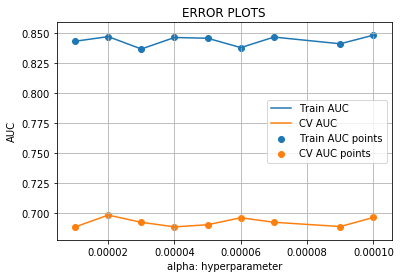

In [117]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf_bow=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',class_weight='balanced')
    sgdclf_bow.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow= CalibratedClassifierCV(sgdclf_bow, method='isotonic', cv=5)
    sgdclfcalibrated_bow.fit(X_tr,y_train)
    
    y_train_pred_bow=sgdclfcalibrated_bow.predict_proba(X_tr)
    y_cv_pred_bow=sgdclfcalibrated_bow.predict_proba(X_cr)
  
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

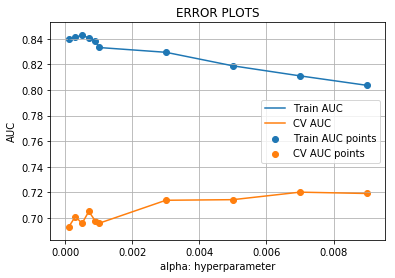

In [118]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf_bow=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',class_weight='balanced')
    sgdclf_bow.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow= CalibratedClassifierCV(sgdclf_bow, method='isotonic', cv=5)
    sgdclfcalibrated_bow.fit(X_tr,y_train)
    
    y_train_pred_bow = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred_bow = sgdclfcalibrated_bow.predict_proba(X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

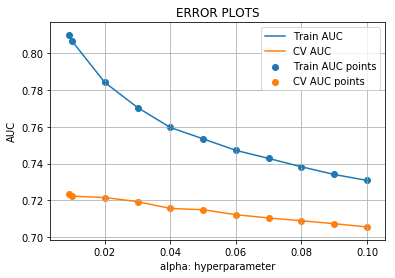

In [121]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
for i in alpha:
    sgdclf_bow=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,class_weight='balanced')
    sgdclf_bow.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow = CalibratedClassifierCV(sgdclf_bow, cv=5, method='isotonic')
    sgdclfcalibrated_bow.fit(X_tr, y_train)
    
    y_train_pred_bow = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred_bow = sgdclfcalibrated_bow.predict_proba(X_cr)   
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

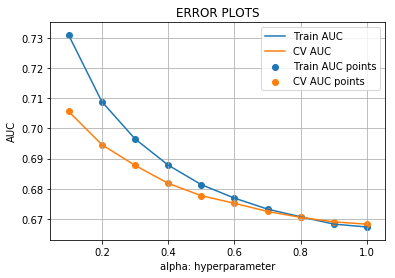

In [124]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in alpha:
    sgdclf_bow=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,class_weight='balanced')
    sgdclf_bow.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow = CalibratedClassifierCV(sgdclf_bow, cv=5, method='isotonic')
    sgdclfcalibrated_bow.fit(X_tr, y_train)
    
    y_train_pred_bow = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred_bow = sgdclfcalibrated_bow.predict_proba(X_cr)   
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

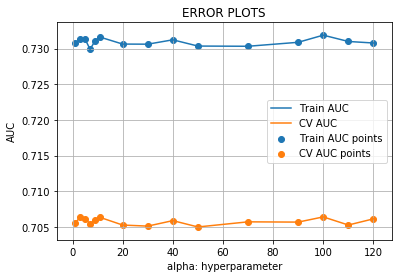

In [123]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [1,3,5,7,9,11,20,30,40,50,70,90,100,110,120]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',class_weight='balanced')
    sgdclf.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow = CalibratedClassifierCV(sgdclf_bow, cv=5, method='isotonic')
    sgdclfcalibrated_bow.fit(X_tr, y_train)
    
    y_train_pred_bow = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred_bow = sgdclfcalibrated_bow.predict_proba(X_cr) 
    
    train_auc.append(roc_auc_score(y_train,y_train_pred_bow[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_bow[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

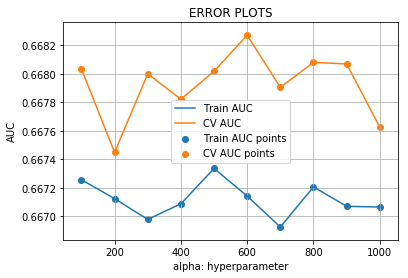

In [125]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [100,200,300,400,500,600,700,800,900,1000]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',class_weight='balanced')
    sgdclf.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow = CalibratedClassifierCV(sgdclf_bow, cv=5, method='isotonic')
    sgdclfcalibrated_bow.fit(X_tr, y_train)
    
    y_train_pred = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred = sgdclfcalibrated_bow.predict_proba(X_cr)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

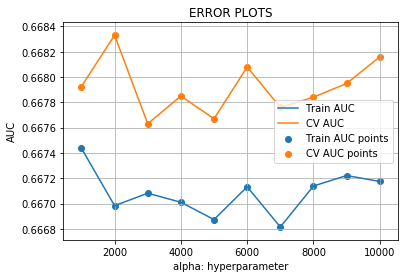

In [127]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',class_weight='balanced')
    sgdclf.fit(X_tr,y_train)
    
    sgdclfcalibrated_bow = CalibratedClassifierCV(sgdclf_bow, cv=5, method='isotonic')
    sgdclfcalibrated_bow.fit(X_tr, y_train)
    
    y_train_pred = sgdclfcalibrated_bow.predict_proba(X_tr)    
    y_cv_pred = sgdclfcalibrated_bow.predict_proba(X_cr)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### best_alpha_bow=0.009

In [128]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

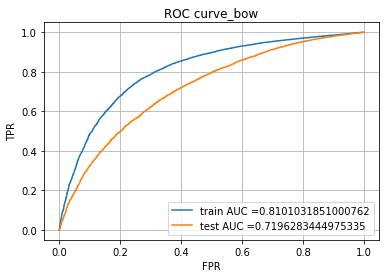

In [129]:
sgdclf=linear_model.SGDClassifier(alpha=0.009,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1500,class_weight='balanced')
sgdclf.fit(X_tr,y_train)

sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
sgdclfcalibrated.fit(X_tr, y_train)
y_train_cccv_bow=sgdclfcalibrated.predict_proba(X_tr)
y_test_cccv_bow=sgdclfcalibrated.predict_proba(X_te)

train_fpr_bow, train_tpr_bow, tr_thresholds_bow = roc_curve(y_train, y_train_cccv_bow[:,1])
test_fpr_bow, test_tpr_bow, te_thresholds_bow = roc_curve(y_test, y_test_cccv_bow[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve_bow")
plt.grid()
plt.show()

In [130]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
set1con_train_bow_cccv=confusion_matrix(y_train, predict(y_train_cccv_bow[:,1], tr_thresholds_bow, train_fpr_bow, train_fpr_bow))
print(set1con_train_bow_cccv)
print("Test confusion matrix")
set1con_test_bow_cccv=confusion_matrix(y_test, predict(y_test_cccv_bow[:,1], tr_thresholds_bow, test_fpr_bow, test_fpr_bow))
print(set1con_test_bow_cccv)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.746
[[ 3713  3713]
 [ 4281 37334]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 0.835
[[ 3731  1728]
 [10983 19610]]


In [189]:
#code from (https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix,class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [132]:
class_names=[0,1]

                     CONFUSION_MATRIX OF TRAIN DATA


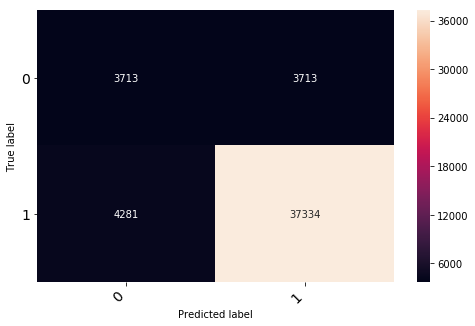

In [134]:
print('                     CONFUSION_MATRIX OF TRAIN DATA')
print_confusion_matrix(set1con_train_bow_cccv,class_names, figsize = (8,5), fontsize=14);

                     CONFUSION_MATRIX OF TEST DATA


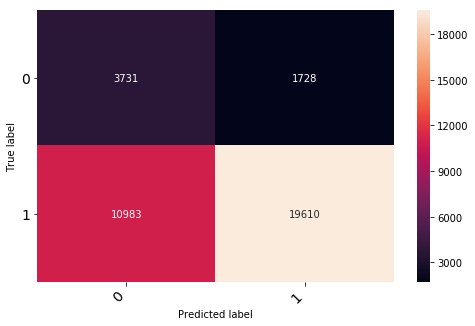

In [135]:
print('                     CONFUSION_MATRIX OF TEST DATA')
print_confusion_matrix(set1con_test_bow_cccv,class_names, figsize = (8,5), fontsize=14);

### Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

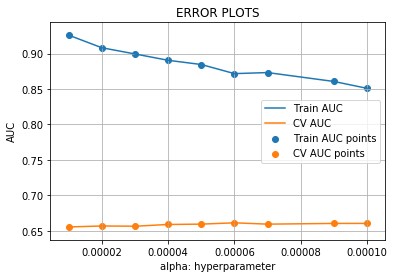

In [137]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2',tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf) 
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

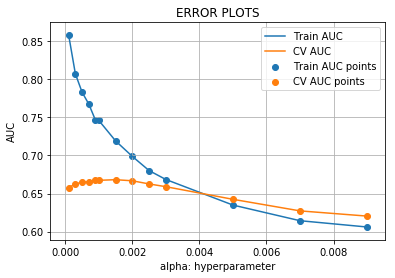

In [140]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.0015,0.002,0.0025,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

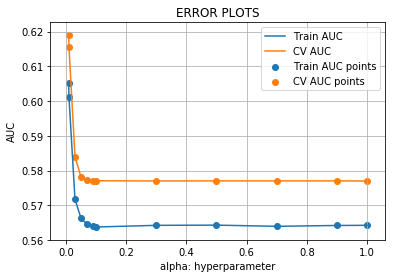

In [139]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9,1]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf) 
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

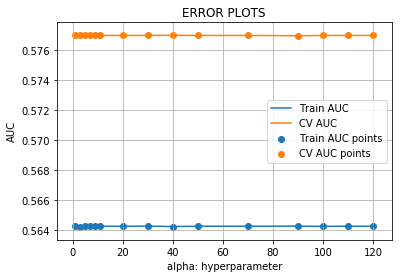

In [141]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [1,3,5,7,9,11,20,30,40,50,70,90,100,110,120]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf) 
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

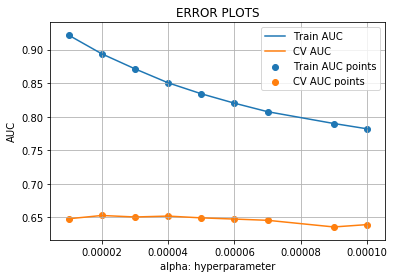

In [143]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l1',tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

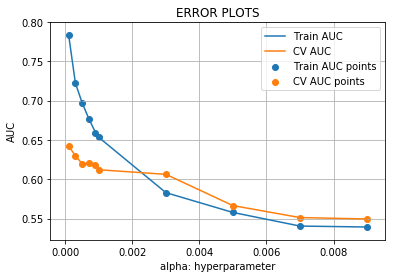

In [144]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l1', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf)  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

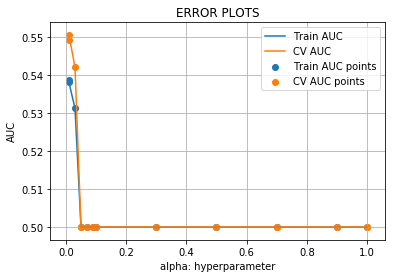

In [145]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9,1]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l1', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf,y_train)
    
    sgdclfcalibrated_tfidf= CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)
    
    y_train_pred = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
    y_cv_pred = sgdclfcalibrated_tfidf.predict_proba(X_cr_tfidf)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### best_alpha_tfidf=0.0015

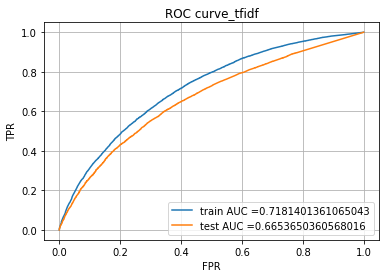

In [151]:
from sklearn.metrics import roc_curve, auc

sgdclf_tfidf=linear_model.SGDClassifier(alpha=0.0015,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
sgdclf_tfidf.fit(X_tr_tfidf,y_train)

sgdclfcalibrated_tfidf = CalibratedClassifierCV(sgdclf_tfidf, cv=5, method='isotonic')
sgdclfcalibrated_tfidf.fit(X_tr_tfidf, y_train)


y_train_pred_tfidf = sgdclfcalibrated_tfidf.predict_proba(X_tr_tfidf)    
y_test_pred_tfidf = sgdclfcalibrated_tfidf.predict_proba(X_te_tfidf)

train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred_tfidf[:,1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_pred_tfidf[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve_tfidf")
plt.grid()
plt.show()

In [152]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
set2con_train=confusion_matrix(y_train, predict(y_train_pred_tfidf[:,1], tr_thresholds_tfidf, train_fpr_tfidf, train_fpr_tfidf))
print(set2con_train)
print("Test confusion matrix")
set2con_test=confusion_matrix(y_test, predict(y_test_pred_tfidf[:,1], te_thresholds_tfidf, test_fpr_tfidf, test_fpr_tfidf))
print(set2con_test)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999818661462 for threshold 0.804
[[ 3714  3712]
 [ 8446 33169]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 0.581
[[ 2730  2729]
 [ 8304 22289]]


                     CONFUSION_MATRIX OF TRAIN DATA


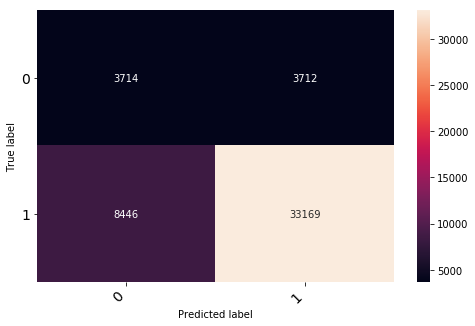

In [153]:
print('                     CONFUSION_MATRIX OF TRAIN DATA')
print_confusion_matrix(set2con_train,class_names, figsize = (8,5), fontsize=14);

                     CONFUSION_MATRIX OF TEST DATA


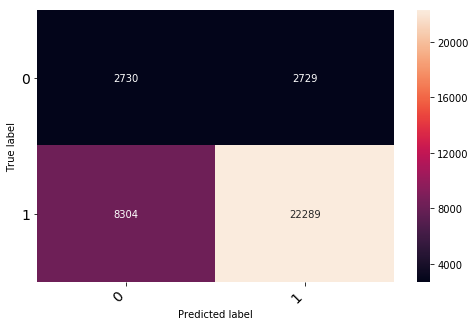

In [154]:
print('                     CONFUSION_MATRIX OF TEST DATA')
print_confusion_matrix(set2con_test,class_names, figsize = (8,5), fontsize=14);

## Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

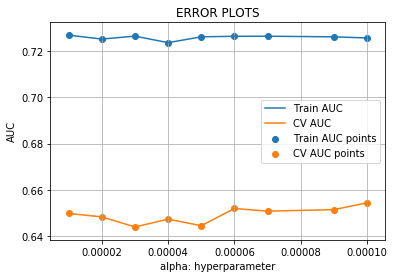

In [156]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_avgw2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_avgw2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_avgw2v)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

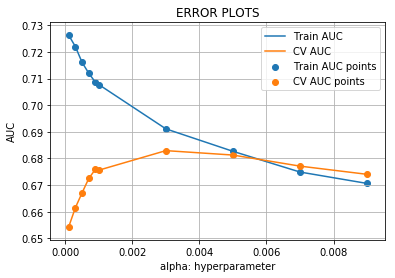

In [157]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_avgw2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_avgw2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_avgw2v)  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1 ]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

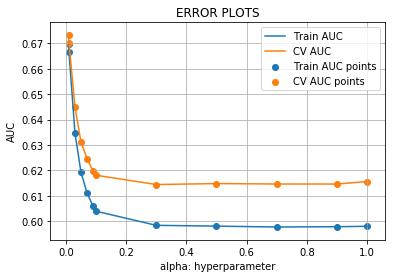

In [158]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9,1]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_avgw2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_avgw2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_avgw2v)  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

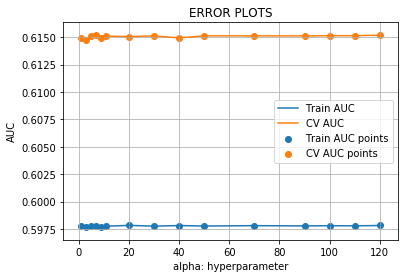

In [160]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [1,3,5,7,9,11,20,30,40,50,70,90,100,110,120]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_avgw2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_avgw2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_avgw2v)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

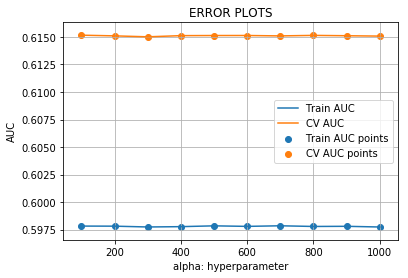

In [161]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [100,200,300,400,500,600,700,800,900,1000]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_avgw2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_avgw2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_avgw2v)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### best_alpha_avgw2v=0.005

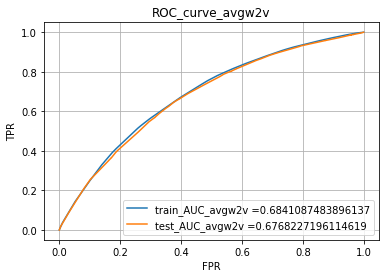

In [162]:
from sklearn.metrics import roc_curve, auc

sgdclf_avgw2v=linear_model.SGDClassifier(alpha=0.005,loss='hinge',class_weight='balanced')
sgdclf_avgw2v.fit(X_tr_avgw2v,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
sgdclfcalibrated_avgw2v = CalibratedClassifierCV(sgdclf_avgw2v, cv='prefit', method='isotonic')
sgdclfcalibrated_avgw2v.fit(X_tr_avgw2v,y_train)

y_train_pred_avgw2v = sgdclfcalibrated_avgw2v.predict_proba(X_tr_avgw2v)    
y_test_pred_avgw2v = sgdclfcalibrated_avgw2v.predict_proba(X_te_avgw2v)
train_fpr_avgw2v, train_tpr_avgw2v, tr_thresholds_avgw2v = roc_curve(y_train, y_train_pred_avgw2v[:,1])
test_fpr_avgw2v, test_tpr_avgw2v, te_thresholds_avgw2v = roc_curve(y_test, y_test_pred_avgw2v[:,1])

plt.plot(train_fpr_avgw2v, train_tpr_avgw2v, label="train_AUC_avgw2v ="+str(auc(train_fpr_avgw2v, train_tpr_avgw2v)))
plt.plot(test_fpr_avgw2v, test_tpr_avgw2v, label="test_AUC_avgw2v ="+str(auc(test_fpr_avgw2v, test_tpr_avgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_curve_avgw2v")
plt.grid()
plt.show()

In [164]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
set3con_train=confusion_matrix(y_train, predict(y_train_pred_avgw2v[:,1], tr_thresholds_avgw2v, train_fpr_avgw2v, train_fpr_avgw2v))
print(set3con_train)
print("Test confusion matrix")
set3con_test=confusion_matrix(y_test, predict(y_test_pred_avgw2v[:,1], te_thresholds_avgw2v, test_fpr_avgw2v, test_fpr_avgw2v))
print(set3con_test)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2498397692677456 for threshold 0.839
[[ 3807  3619]
 [10190 31425]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24966107318151554 for threshold 0.759
[[ 2830  2629]
 [ 7991 22602]]


                     CONFUSION_MATRIX OF TRAIN DATA


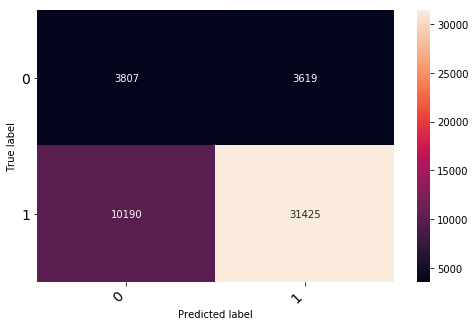

In [165]:
print('                     CONFUSION_MATRIX OF TRAIN DATA')
print_confusion_matrix(set3con_train,class_names, figsize = (8,5), fontsize=14);

                     CONFUSION_MATRIX OF TEST DATA


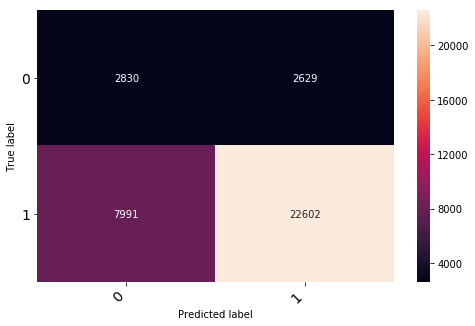

In [166]:
print('                     CONFUSION_MATRIX OF TEST DATA')
print_confusion_matrix(set3con_test,class_names, figsize = (8,5), fontsize=14);

## Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

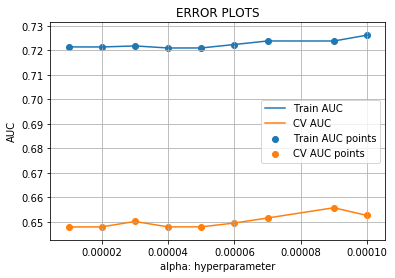

In [168]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf_w2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_tfidf_w2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_tfidf_w2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_tfidf_w2v)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

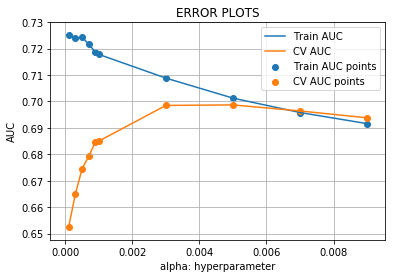

In [170]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf_w2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_tfidf_w2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_tfidf_w2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_tfidf_w2v)  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

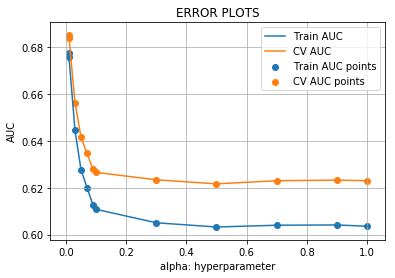

In [171]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9,1]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_tfidf_w2v,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_avgw2v, y_train)
    
    y_train_pred = sgdclfcalibrated.predict_proba(X_tr_tfidf_w2v)    
    y_cv_pred = sgdclfcalibrated.predict_proba(X_cr_tfidf_w2v)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


#### best_alpha_tfidf_w2v=0.005

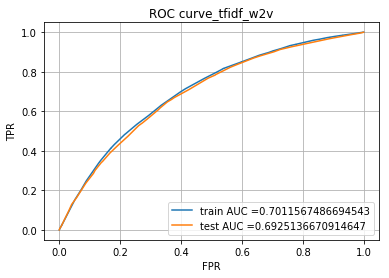

In [172]:
from sklearn.metrics import roc_curve, auc

sgdclf_tfidf_w2v=linear_model.SGDClassifier(alpha=0.005,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
sgdclf_tfidf_w2v.fit(X_tr_tfidf_w2v,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
sgdclfcalibrated_tfidf_w2v = CalibratedClassifierCV(sgdclf_tfidf_w2v, cv='prefit', method='isotonic')
sgdclfcalibrated_tfidf_w2v.fit(X_tr_avgw2v,y_train)


y_train_pred_tfidf_w2v = sgdclfcalibrated_tfidf_w2v.predict_proba(X_tr_tfidf_w2v)    
y_test_pred_tfidf_w2v = sgdclfcalibrated_tfidf_w2v.predict_proba(X_te_tfidf_w2v)
train_fpr_tfidf_w2v, train_tpr_tfidf_w2v, tr_thresholds_tfidf_w2v = roc_curve(y_train, y_train_pred_tfidf_w2v[:,1])
test_fpr_tfidf_w2v, test_tpr_tfidf_w2v, te_thresholds_tfidf_w2v = roc_curve(y_test, y_test_pred_tfidf_w2v[:,1])

plt.plot(train_fpr_tfidf_w2v, train_tpr_tfidf_w2v, label="train AUC ="+str(auc(train_fpr_tfidf_w2v, train_tpr_tfidf_w2v)))
plt.plot(test_fpr_tfidf_w2v, test_tpr_tfidf_w2v, label="test AUC ="+str(auc(test_fpr_tfidf_w2v, test_tpr_tfidf_w2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve_tfidf_w2v")
plt.grid()
plt.show()

In [173]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
set4con_train=confusion_matrix(y_train, predict(y_train_pred_tfidf_w2v[:,1], tr_thresholds_tfidf_w2v, train_fpr_tfidf_w2v, train_fpr_tfidf_w2v))
print(set4con_train)
print("Test confusion matrix")
set4con_test=confusion_matrix(y_test, predict(y_test_pred_tfidf_w2v[:,1], tr_thresholds_tfidf_w2v, test_fpr_tfidf_w2v, test_fpr_tfidf_w2v))
print(set4con_test)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24978058036891368 for threshold 0.852
[[ 3603  3823]
 [ 8476 33139]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24996455617910207 for threshold 0.781
[[ 2788  2671]
 [ 7101 23492]]


                     CONFUSION_MATRIX OF TRAIN DATA


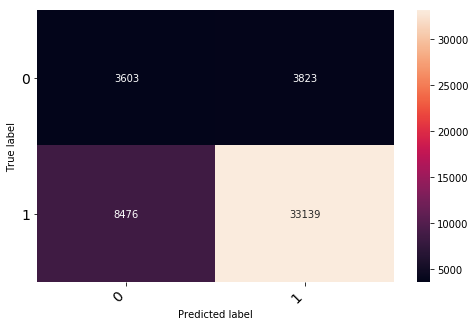

In [174]:
print('                     CONFUSION_MATRIX OF TRAIN DATA')
print_confusion_matrix(set4con_train,class_names, figsize = (8,5), fontsize=14);

                     CONFUSION_MATRIX OF TEST DATA


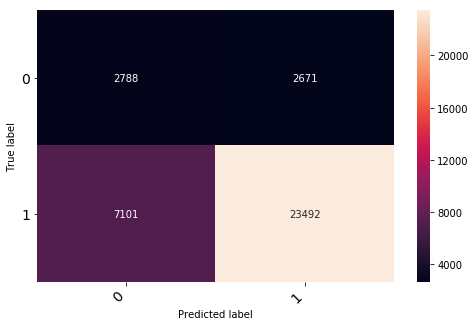

In [175]:
print('                     CONFUSION_MATRIX OF TEST DATA')
print_confusion_matrix(set4con_test,class_names, figsize = (8,5), fontsize=14);

# set 5

In [117]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ss\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [118]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

C:\Users\ss\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

In [119]:
ssdict={ }

In [120]:
for i in range (0,49041):
    ssdict[i] = sid.polarity_scores(X_train['essay'][i])

In [121]:
ssdf=pd.DataFrame.from_dict(ssdict)

In [122]:
ssdf=ssdf.T

In [123]:
ssdf.head()

compound    neg    neu    pos
0    0.9921  0.007  0.840  0.153
1    0.9650  0.024  0.848  0.129
2    0.9978  0.020  0.721  0.258
3    0.9717  0.033  0.811  0.156
4    0.9723  0.017  0.869  0.114

In [124]:
length_train={ }

In [125]:
for i in range(0,49041):
    length_train[i]=len(X_train['essay'][i])

In [126]:
length_train_df=pd.DataFrame.from_dict(length_train,orient='index')

In [127]:
ssdict_cv={ }

In [128]:
for i in range (0,24155):
    ssdict_cv[i] = sid.polarity_scores(X_cv['essay'][i])

In [129]:
ssdf_cv=pd.DataFrame.from_dict(ssdict_cv)

In [130]:
ssdf_cv=ssdf_cv.T

In [131]:
length_cv={ }

In [132]:
for i in range(0,24155):
    length_cv[i]=len(X_cv['essay'][i])

In [133]:
length_cv_df=pd.DataFrame.from_dict(length_cv,orient='index')

In [134]:
ssdict_test={ }

In [135]:
for i in range (0,36052):
    ssdict_test[i] = sid.polarity_scores(X_test['essay'][i])

In [136]:
ssdf_test=pd.DataFrame.from_dict(ssdict_test)

In [137]:
ssdf_test=ssdf_test.T

In [138]:
length_test={ }

In [139]:
for i in range(0,36052):
    length_test[i]=len(X_test['essay'][i])

In [140]:
length_test_df=pd.DataFrame.from_dict(length_test,orient='index')

In [141]:
length_test_title={ }

In [142]:
for i in range(0,36052):
    length_test_title[i]=len(X_test['project_title'][i])

In [143]:
length_train_title={ }

In [144]:
length_train_title_df=pd.DataFrame.from_dict(length_train_title,orient='index')

In [145]:
for i in range(0,49041):
    length_train_title[i]=len(X_train['project_title'][i])

In [146]:
length_train_title_df=pd.DataFrame.from_dict(length_train_title,orient='index')

In [147]:
length_test_title_df=pd.DataFrame.from_dict(length_test_title,orient='index')

In [148]:
length_cv_title={ }

In [149]:
for i in range(0,24155):
    length_cv_title[i]=len(X_cv['project_title'][i])

In [150]:
length_cv_title_df=pd.DataFrame.from_dict(length_cv_title,orient='index')

In [151]:
length_scaled= min_max_scaler.fit(length_train_df.values.reshape(-1,1))
length_scaled_train=length_scaled.transform(length_train_df.values.reshape(-1,1))
length_normalized_train=pd.DataFrame(length_scaled_train)

C:\Users\ss\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [152]:
length_scaled_cv=length_scaled.transform(length_cv_df.values.reshape(-1,1))
length_normalized_cv=pd.DataFrame(length_scaled_cv)

In [153]:
length_scaled_test=length_scaled.transform(length_test_df.values.reshape(-1,1))
length_normalized_test=pd.DataFrame(length_scaled_test)

In [154]:
length_scaled_title= min_max_scaler.fit(length_train_title_df.values.reshape(-1,1))
length_scaled_train_title=length_scaled_title.transform(length_train_title_df.values.reshape(-1,1))
length_normalized_train_title=pd.DataFrame(length_scaled_train_title)

C:\Users\ss\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



In [155]:
length_scaled_cv_title=length_scaled_title.transform(length_cv_title_df.values.reshape(-1,1))
length_normalized_cv_title=pd.DataFrame(length_scaled_cv_title)

In [156]:
length_scaled_test_title=length_scaled_title.transform(length_test_title_df.values.reshape(-1,1))
length_normalized_test_title=pd.DataFrame(length_scaled_test_title)

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10)
vectorizer_tfidf = vectorizer_tfidf.fit(preprocessed_essays_train)
text_tfidf_train = vectorizer_tfidf.transform(preprocessed_essays_train)
print("Shape of matrix after one hot encodig ",text_tfidf_train.shape)
text_tfidf_test = vectorizer_tfidf.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encodig ",text_tfidf_test.shape)

Shape of matrix after one hot encodig  (49041, 12130)
Shape of matrix after one hot encodig  (36052, 12130)


In [158]:
from sklearn.decomposition import TruncatedSVD

In [159]:
text_tfidf_train

<49041x12130 sparse matrix of type '<class 'numpy.float64'>'
	with 5227457 stored elements in Compressed Sparse Row format>

In [160]:
text_tfidf_train2=text_tfidf_train

In [161]:
text_tfidf_train2

<49041x12130 sparse matrix of type '<class 'numpy.float64'>'
	with 5227457 stored elements in Compressed Sparse Row format>

In [162]:
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [163]:
svd.fit(text_tfidf_train2)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=7,
       random_state=42, tol=0.0)

In [164]:
w=svd.transform(text_tfidf_train2)

In [165]:
text_tfidf_train2

<49041x12130 sparse matrix of type '<class 'numpy.float64'>'
	with 5227457 stored elements in Compressed Sparse Row format>

In [166]:
w.shape

(49041, 5)

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_2 = TfidfVectorizer(min_df=10, max_features=3000)
vectorizer_tfidf_2 = vectorizer_tfidf_2.fit(preprocessed_essays_train)
text_tfidf_train_2 = vectorizer_tfidf_2.transform(preprocessed_essays_train)
print("Shape of matrix after one hot encodig ",text_tfidf_train_2.shape)

Shape of matrix after one hot encodig  (49041, 3000)


In [168]:
text_tfidf_test_2 = vectorizer_tfidf_2.transform(preprocessed_essays_test)
print("Shape of matrix after one hot encodig ",text_tfidf_test_2.shape)

Shape of matrix after one hot encodig  (36052, 3000)


In [169]:
text_tfidf_cv_2 = vectorizer_tfidf_2.transform(preprocessed_essays_cv)
print("Shape of matrix after one hot encodig ",text_tfidf_cv_2.shape)

Shape of matrix after one hot encodig  (24155, 3000)


In [173]:
index = [5,10,50,100,250 ,500,1000]
variance_sum = []
for i in tqdm(index):
    svd = TruncatedSVD(n_components=i, n_iter= 5, random_state=5)
    svd.fit(text_tfidf_train2)
    variance_sum.append(svd.explained_variance_ratio_.sum()) 

In [169]:
variance_sum

[0.03353463396110956,
 0.052733137317166834,
 0.13080993364685495,
 0.18844685293890068,
 0.30132541901216237,
 0.4229872429709633,
 0.5717369222661447,
 0.7824614324834618,
 0.8212199442194856]

Text(0.5,1,'elbow_method')

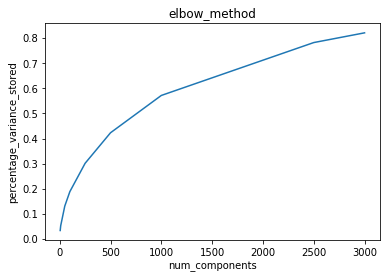

In [171]:
plt.plot(index,variance_sum)
plt.ylabel('percentage_variance_stored')
plt.xlabel('num_components')
plt.title('elbow_method')

In [174]:
X_tr_set5_2 = hstack((categories_one_hot_train,sub_categories_one_hot_train,categories_one_hot_train_tp,teacher_one_hot_train,categories_one_hot_grade,ssdf, price_normalized_train,quantity_normalized_train,tpp_normalized_train,length_normalized_train,length_normalized_train_title,text_tfidf_train_2)).tocsr()

In [175]:
X_cr_set5_2 = hstack((categories_one_hot_cv,sub_categories_one_hot_cv,categories_one_hot_cv_tp,teacher_one_hot_cv,categories_one_hot_grade_cv,ssdf_cv, price_normalized_cv,quantity_normalized_cv,tpp_normalized_cv,length_normalized_cv,length_normalized_cv_title,text_tfidf_cv_2)).tocsr()

In [176]:
X_te_set5_2 = hstack((categories_one_hot_test,sub_categories_one_hot_test,categories_one_hot_test_tp,teacher_one_hot_test,categories_one_hot_grade_test,ssdf_test, price_normalized_test,quantity_normalized_test,tpp_normalized_test,length_normalized_test,length_normalized_test_title,text_tfidf_test_2)).tocsr()

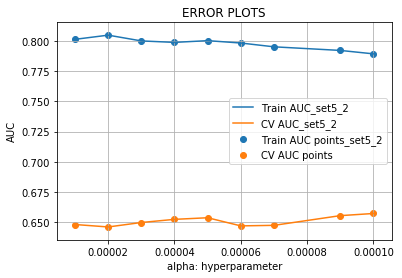

In [180]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00009,0.0001]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_set5_2,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_set5_2, y_train)
    
    y_train_pred_set5_2 = sgdclfcalibrated.predict_proba(X_tr_set5_2)    
    y_cv_pred_set5_2 = sgdclfcalibrated.predict_proba(X_cr_set5_2)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred_set5_2[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_set5_2[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC_set5_2')
plt.plot(alpha, cv_auc, label='CV AUC_set5_2')
plt.scatter(alpha, train_auc, label='Train AUC points_set5_2')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

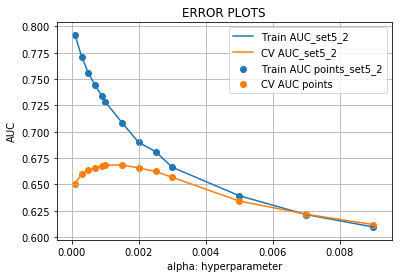

In [183]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.0015,0.002,0.0025,0.003,0.005,0.007,0.009]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_set5_2,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_set5_2, y_train)
    
    y_train_pred_set5_2 = sgdclfcalibrated.predict_proba(X_tr_set5_2)    
    y_cv_pred_set5_2 = sgdclfcalibrated.predict_proba(X_cr_set5_2)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred_set5_2[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_set5_2[:,1]))
plt.plot(alpha, train_auc, label='Train AUC_set5_2')
plt.plot(alpha, cv_auc, label='CV AUC_set5_2')
plt.scatter(alpha, train_auc, label='Train AUC points_set5_2')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

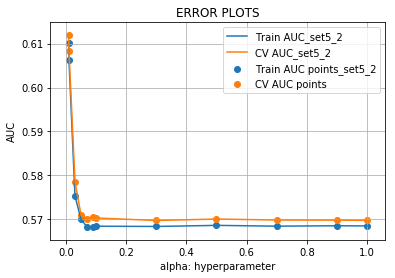

In [185]:
import matplotlib.pyplot as plt #1
from sklearn import linear_model
from sklearn.metrics import roc_auc_score 
train_auc = []
cv_auc = []
alpha = [0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3,0.5,0.7,0.9,1]
for i in alpha:
    sgdclf=linear_model.SGDClassifier(alpha=i,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
    sgdclf.fit(X_tr_set5_2,y_train)
    
    sgdclfcalibrated = CalibratedClassifierCV(sgdclf, cv=5, method='isotonic')
    sgdclfcalibrated.fit(X_tr_set5_2, y_train)
    
    y_train_pred_set5_2 = sgdclfcalibrated.predict_proba(X_tr_set5_2)    
    y_cv_pred_set5_2 = sgdclfcalibrated.predict_proba(X_cr_set5_2)   
    
    train_auc.append(roc_auc_score(y_train,y_train_pred_set5_2[:,1]))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred_set5_2[:,1]))
    
plt.plot(alpha, train_auc, label='Train AUC_set5_2')
plt.plot(alpha, cv_auc, label='CV AUC_set5_2')
plt.scatter(alpha, train_auc, label='Train AUC points_set5_2')
plt.scatter(alpha, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

#### best_alpha_set_5=0.0015

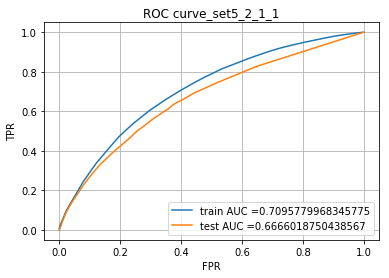

In [186]:
from sklearn.metrics import roc_curve, auc

sgdclf_tfidf_w2v=linear_model.SGDClassifier(alpha=0.0015,loss='hinge',penalty = 'l2', tol=0.0008,max_iter=1200,class_weight='balanced')
sgdclf_tfidf_w2v.fit(X_tr_set5_2,y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
sgdclfcalibrated_tfidf_w2v = CalibratedClassifierCV(sgdclf_tfidf_w2v, cv='prefit', method='isotonic')
sgdclfcalibrated_tfidf_w2v.fit(X_tr_set5_2,y_train)

y_train_pred_set5_2_1_1 = sgdclfcalibrated_tfidf_w2v.predict_proba(X_tr_set5_2)    
y_test_pred_set5_2_1_1 = sgdclfcalibrated_tfidf_w2v.predict_proba(X_te_set5_2)

train_fpr_set5_2_1_1, train_tpr_set5_2_1_1, tr_thresholds_set5_2_1_1 = roc_curve(y_train, y_train_pred_set5_2_1_1[:,1])
test_fpr_set5_2_1_1, test_tpr_set5_2_1_1, te_thresholds_set5_2_1_1 = roc_curve(y_test, y_test_pred_set5_2_1_1[:,1])

plt.plot(train_fpr_set5_2_1_1, train_tpr_set5_2_1_1, label="train AUC ="+str(auc(train_fpr_set5_2_1_1, train_tpr_set5_2_1_1)))
plt.plot(test_fpr_set5_2_1_1, test_tpr_set5_2_1_1, label="test AUC ="+str(auc(test_fpr_set5_2_1_1, test_tpr_set5_2_1_1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve_set5_2_1_1")
plt.grid()
plt.show()

In [187]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
set5con_train_1=confusion_matrix(y_train, predict(y_train_pred_set5_2_1_1[:,1], tr_thresholds_set5_2_1_1, train_fpr_set5_2_1_1, train_fpr_set5_2_1_1))
print(set5con_train_1)
print("Test confusion matrix")
set5con_test_1_1=confusion_matrix(y_test, predict(y_test_pred_set5_2_1_1[:,1], te_thresholds_set5_2_1_1, test_fpr_set5_2_1_1, test_fpr_set5_2_1_1))
print(set5con_test_1_1)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24959198828930226 for threshold 0.811
[[ 3863  3563]
 [ 9384 32231]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2497489235229222 for threshold 0.524
[[ 2643  2816]
 [ 7861 22732]]


                     CONFUSION_MATRIX OF TRAIN DATA


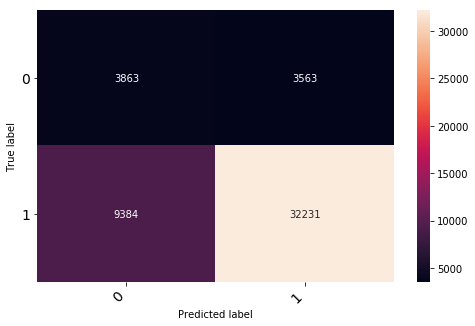

In [194]:
print('                     CONFUSION_MATRIX OF TRAIN DATA')
print_confusion_matrix(set5con_train_1,class_names, figsize = (8,5), fontsize=14);

                     CONFUSION_MATRIX OF TEST DATA


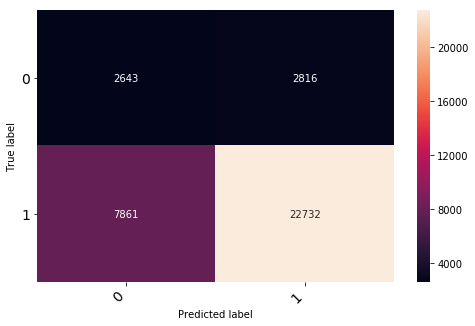

In [195]:
print('                     CONFUSION_MATRIX OF TEST DATA')
print_confusion_matrix(set5con_test_1_1,class_names, figsize = (8,5), fontsize=14);

In [193]:
class_names=[0,1]

In [196]:
from prettytable import PrettyTable
    
P = PrettyTable()

In [197]:
P.field_names = ["set", "text_vectorizer", "Best_alpha","AUC_TRAIN", "AUC_TEST"]

In [198]:
P.add_row(["1","Bow","0.009","0.81","0.719"])
P.add_row(["2","Tfidf","0.0015","0.718","0.665"])
P.add_row(["3","avgw2v","0.005","0.684","0.676"])
P.add_row(["4","tfidfw2v","0.005","0.701","0.692"])
P.add_row(["5","tfidf_3000n","0.0015","0.709","0.667"])

In [199]:
print(P)

+-----+-----------------+------------+-----------+----------+
| set | text_vectorizer | Best_alpha | AUC_TRAIN | AUC_TEST |
+-----+-----------------+------------+-----------+----------+
|  1  |       Bow       |   0.009    |    0.81   |  0.719   |
|  2  |      Tfidf      |   0.0015   |   0.718   |  0.665   |
|  3  |      avgw2v     |   0.005    |   0.684   |  0.676   |
|  4  |     tfidfw2v    |   0.005    |   0.701   |  0.692   |
|  5  |   tfidf_3000n   |   0.0015   |   0.709   |  0.667   |
+-----+-----------------+------------+-----------+----------+


# conclusion:
###                            1.Among all vectorizers Bow is performing well.
###                            2.In set5 number of features are 3000 , it has more than 80% variance and it is performing well 